## Weather Image Recognition - Image Classification

In [204]:
# Import libraries

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [43]:
# GPU computations
# Deep neural networks require quite a lot of computational power to run. 
# If it is available use GPU acceleration to speed up training. Luckily, 
# Keras automatically speeds up the computations on the GPU if it is available. 
# We can check if TensorFlow is able to use GPU using the following code:

tf.config.list_physical_devices('GPU')

# we will set tensorflow option to grow GPU memory allocation when required.

physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Import data

In [205]:
IMAGE_SIZE = (224, 224)
DATASET_PATH = 'C:\\Users\\utente\\Kaggle_competitions_&_datasets\\Weather_Image_Recognition\\dataset\\'
SEED = 13

In [277]:
# directory/subdirectories analysis

for i, (root, dirs, files) in enumerate(os.walk(DATASET_PATH)): # root -> path, dirs -> directories, files -> tot files
    No_of_files = len(os.listdir(root)) # tot of files (included n° of subdirectories)
    if i == 0:
        lab = dirs # class_names
        lab.insert(0,'tot_subdirectories')
    print(f'{lab[i]} -> {No_of_files}')
    
    

tot_subdirectories -> 11
dew -> 698
fogsmog -> 851
frost -> 475
glaze -> 639
hail -> 591
lightning -> 377
rain -> 526
rainbow -> 232
rime -> 1160
sandstorm -> 692
snow -> 621


### train/validation split

In [64]:
# Keras includes a helper function image_dataset_from_directory, which can load images from subdirectories 
# corresponding to different classes. 
# This function takes care of scaling images, and it can split dataset into train and validation/test subsets:

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=32,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset = 'training',

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=32,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset = 'validation',
)

Found 6862 files belonging to 11 classes.
Using 4804 files for training.
Found 6862 files belonging to 11 classes.
Using 2058 files for validation.


In [28]:
class_names = train_ds.class_names
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

 ## Transfer Learning with pre-trained model

In [29]:
# Can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?
# This approach is called transfer learning, because we transfer some knowledge from one neural network model to another. 
# In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, 
# such as ImageNet. Those models already do a good job extracting different features from generic images, 
# and in many cases just building a classifier on top of those extracted features can yield a good result.

# There are many pre-trained neural networks for image classification.
# Computer vision models
# VGG-16 is one of the simplest computer vision architectures. Keras provides many more pre-trained networks. 
# The most frequently used ones among those are ResNet architectures, developed by Microsoft, and Inception by Google.
# Many of those models are available inside the keras.applications namespace, and even more models can be found on the Internet.

# We will use Xception-Net
# N.B.: Before passing an input to any pre-trained network it has to be pre-processed in a certain way. 
# This is done by calling corresponding preprocess_input function, which receives a batch of images, 
# and returns their processed form.



### Image Pre-Processing

In [30]:
def process(img, lab):
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, lab

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [31]:
for x, y in train_ds:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    break

Training batch shape: features=(32, 224, 224, 3), labels=(32,)


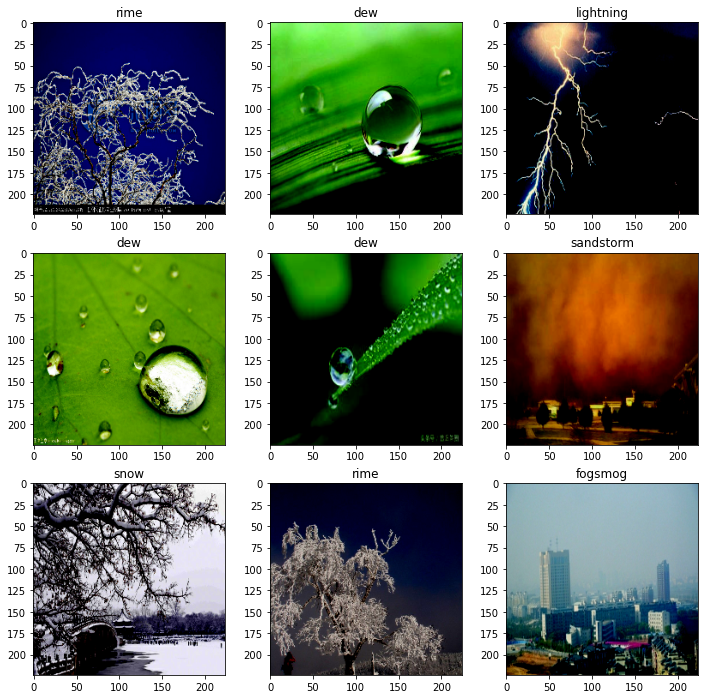

In [32]:
plt.figure(figsize=(12, 12))

for x, y in train_ds.skip(3).take(1):
    for i, (img, lab) in enumerate(zip(x, y)):
        if i>=9:
            break
        plt.subplot(3, 3, i+1)
        img = img.numpy()
        img = np.clip(img, 0, 1)  #if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
        lab = lab.numpy()
#         print(img.min(), img.max())
        plt.imshow(img)
        plt.title(class_names[lab])

### Data Modeling with CNNs

### import Pretrained model

In [33]:
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
)

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

                                                                                                  
 block4_sepconv1 (SeparableConv  (None, None, None,   188672     ['block4_sepconv1_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, None, None,   2912       ['block4_sepconv1[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 block4_sepconv2_act (Activatio  (None, None, None,   0          ['block4_sepconv1_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block4_se

 lization)                      728)                                                              
                                                                                                  
 add_4 (Add)                    (None, None, None,   0           ['block6_sepconv3_bn[0][0]',     
                                728)                              'add_3[0][0]']                  
                                                                                                  
 block7_sepconv1_act (Activatio  (None, None, None,   0          ['add_4[0][0]']                  
 n)                             728)                                                              
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, None, None,   536536     ['block7_sepconv1_act[0][0]']    
 2D)                            728)                                                              
          

 block9_sepconv3_act (Activatio  (None, None, None,   0          ['block9_sepconv2_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block9_sepconv3 (SeparableConv  (None, None, None,   536536     ['block9_sepconv3_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, None, None,   2912       ['block9_sepconv3[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 add_7 (Add)                    (None, None, None,   0           ['block9_sepconv3_bn[0][0]',     
          

                                                                                                  
 block12_sepconv2 (SeparableCon  (None, None, None,   536536     ['block12_sepconv2_act[0][0]']   
 v2D)                           728)                                                              
                                                                                                  
 block12_sepconv2_bn (BatchNorm  (None, None, None,   2912       ['block12_sepconv2[0][0]']       
 alization)                     728)                                                              
                                                                                                  
 block12_sepconv3_act (Activati  (None, None, None,   0          ['block12_sepconv2_bn[0][0]']    
 on)                            728)                                                              
                                                                                                  
 block12_s

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(11, activation='softmax')

# CNN model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 11)                22539     
                                                                 
Total params: 20,884,019
Trainable params: 20,829,491
Non-trainable params: 54,528
_________________________________________________________________


### Training upperlayers

In [35]:
# The tricky thing is that we want Xception to act as a feature extractor, and not to be re-trained. 
# Thus, we need to freeze weights of convolutional feature extractor. We just need to set trainable property to False.

base_model.trainable = False

model.compile(
    loss='sparse_categorical_crossentropy',\
    optimizer='adam',
    metrics = ['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=2)

Epoch 1/2
151/151 [==============================] - 593s 4s/step - loss: 1.0197 - accuracy: 0.6998 - val_loss: 0.6895 - val_accuracy: 0.7828
Epoch 2/2
151/151 [==============================] - 671s 4s/step - loss: 0.5479 - accuracy: 0.8310 - val_loss: 0.5787 - val_accuracy: 0.8027


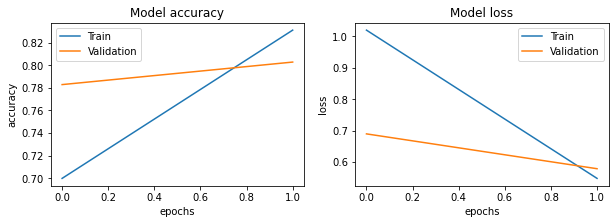

In [36]:
# Plotting Accuracy, val_accuracy, loss, val_loss

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Validation'])

### Fine Tuning

In [37]:
# Unfreeze the base model

base_model.trainable = True

adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001, # 10^-4, very low learning rate
)

model.compile(
    loss='sparse_categorical_crossentropy',\
    optimizer=adam_optimizer,
    metrics = ['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=1)

151/151 [==============================] - 2255s 15s/step - loss: 0.7351 - accuracy: 0.7983 - val_loss: 0.5012 - val_accuracy: 0.8304


In [53]:
model.save('./wheater_image_recognition.h5')

### Testing

In [39]:
def predict(model, img_url=None, file_path=None):
    
    if file_path == None:
        file_path = tf.keras.utils.get_file(origin=img_url)
        
    img = tf.keras.utils.load_img(
        file_path,
        target_size=IMAGE_SIZE
    )
    img = np.asarray(img)
    img, _ = process(img, '')
    plt.imshow(np.clip(img, 0, 1))
    img = img.reshape([1, *IMAGE_SIZE, 3])
    # img.shape
    pred = model.predict(img)
    plt.title(class_names[np.argmax(pred)])
    plt.show()

1/1 [==============================] - 1s 869ms/step


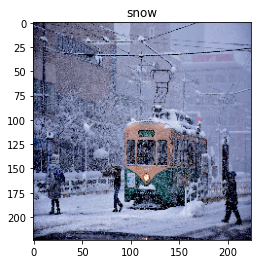

1/1 [==============================] - 1s 873ms/step


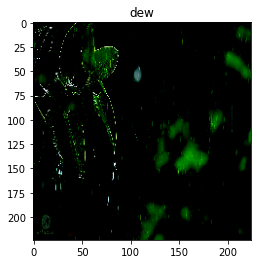

1/1 [==============================] - 1s 875ms/step


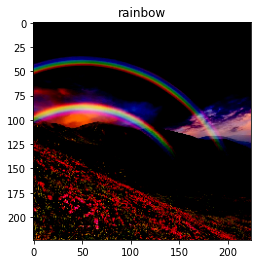

In [52]:
file_paths = ["C:\\Users\\utente\\Kaggle_competitions_&_datasets\\Weather_Image_Recognition\\test\\-1x-1.jpg",
             "C:\\Users\\utente\\Kaggle_competitions_&_datasets\\Weather_Image_Recognition\\test\\maxresdefault.jpg",
             "C:\\Users\\utente\\Kaggle_competitions_&_datasets\\Weather_Image_Recognition\\test\\Rainbow01.webp"]

for file_path in file_paths:
    predict(model, file_path=file_path)